## Copy data to new directory

In [16]:
import os
import shutil
import pandas as pd
from os.path import join as opj

source_dir = r'/mnt/data/Project/DCM/BIDS/sourcedata'
output_dir = r'/media/dell/96E3-021E/Data2HeLi'
# read data from source directory
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')

# copy meg data
data = participants_data.query('meg_neuro==1')
pid = data['Participant_ID'].to_list()
subject_list = pid

# creat directory structure in output directory
def copy_meg_resting(sub_id):
    original_dir = r'/mnt/workdir/DCM/sourcedata'
    output_dir = '/media/dell/96E3-021E/Data2HeLi'

    sourMegDir = opj(original_dir, sub_id, 'NeuroData','MEG')
    targMegDir = opj(output_dir, sub_id, 'MEG')

    if not os.path.exists(targMegDir):
        os.makedirs(targMegDir)

    file_list = os.listdir(sourMegDir)
    target_files = []
    for f in file_list:
        if 'rest' in f:
            target_files.append(f)
        else:
            continue

    for target_file in target_files:
        source_file_path = opj(sourMegDir,target_file)
        target_file_path = opj(targMegDir,target_file)
        if '.fif' in target_file:
            shutil.copy(source_file_path,target_file_path)
        elif '.ds' in target_file:
            shutil.copytree(source_file_path,target_file_path)

for sub in subject_list:
    copy_meg_resting(sub)

OSError: [Errno 28] No space left on device: '/mnt/workdir/DCM/sourcedata/sub_066/NeuroData/MEG/rest2_tsss.fif' -> '/media/dell/96E3-021E/Data2HeLi/sub_066/MEG/rest2_tsss.fif'

In [ ]:
# copy fmri resting data and T1
def copy_mri_resting(sub_id):
    original_dir = r'/mnt/workdir/DCM/BIDS'
    output_dir = '/media/dell/96E3-021E/Data2HeLi'

    sourMriDir = opj(original_dir, sub_id)
    targMriDir = opj(output_dir, sub_id, 'MRI')

    if not os.path.exists(targMriDir):
        os.makedirs(targMriDir)

    mri_modes = ['anat','fmap','func']

    for mode in mri_modes:
        if mode in ['anat','fmap']:
            source_file_path = opj(sourMriDir,mode)
            target_file_path = opj(targMriDir,mode)
            shutil.copytree(source_file_path,target_file_path)
        elif mode == 'func':
            file_list = os.listdir(sourMriDir)
            target_files = []
            for f in file_list:
                if 'rest' in f:
                    target_files.append(f)
                else:
                    continue
            for target_file in target_files:
                source_file_path = opj(sourMriDir,mode,target_file)
                target_file_path = opj(targMriDir,mode,target_file)
                shutil.copy(source_file_path,target_file_path)

## copy event file to new directory

In [20]:
import os
import shutil
from os.path import join as opj

source_dir = r'/mnt/data/Project/DCM/BIDS/derivatives/fmriprep_surfer'
output_dir = r'/mnt/data/Project/DCM/BIDS/derivatives/Events'
# read data from source directory
sub_list = ['sub-{}'.format(str(idx).zfill(3)) for idx in range(12,48)]
# creat directory structure in output directory
for i,sub in enumerate(sub_list):
    if not os.path.exists(opj(source_dir, sub, 'events')):
        print(sub, " haven't event files.")
        continue
    for event_type in ['hexonM2Long', 'hexonM2Short', 'hexonRule']:
        souEvPath = opj(source_dir, sub, 'events',event_type)
        tarSubdir = (opj(output_dir, sub))
        if not os.path.exists(tarSubdir):
            os.mkdir(tarSubdir)
        tarEvPath = opj(output_dir, sub, event_type)
        #shutil.move(souEvPath, tarEvPath)
        
        try:
            shutil.move(souEvPath, tarEvPath)
        except:
            if os.path.exists(tarEvPath):
                print("Error: {} file can't be moved!".format(sub))
            else:
                print("{} haven't {}".format(sub,event_type))

    print("————————{} already been copyed. still have {} subject ————————".format(sub,len(sub_list)-i-1))
    os.rmdir(opj(source_dir, sub, 'events'))
    

sub-012  haven't event files.
sub-013  haven't event files.
————————sub-014 already been copyed. still have 33 subject ————————
————————sub-014 already been copyed. still have 33 subject ————————
————————sub-014 already been copyed. still have 33 subject ————————
————————sub-015 already been copyed. still have 32 subject ————————
sub-015 haven't hexonM2Short
————————sub-015 already been copyed. still have 32 subject ————————
————————sub-016 already been copyed. still have 31 subject ————————
sub-016 haven't hexonM2Short
————————sub-016 already been copyed. still have 31 subject ————————
————————sub-017 already been copyed. still have 30 subject ————————
————————sub-017 already been copyed. still have 30 subject ————————
————————sub-017 already been copyed. still have 30 subject ————————
————————sub-018 already been copyed. still have 29 subject ————————
————————sub-018 already been copyed. still have 29 subject ————————
————————sub-018 already been copyed. still have 29 subject ———————

## Convert formate of event files to fsl format

In [6]:
import os
import numpy as np
import pandas as pd 
from os.path import join as opj


def ev2fsl(ev_file,save_dir,prefix):
    ev_info = pd.read_csv(ev_file, sep='\t')
    for group in ev_info.groupby('trial_type'):
        condition = group[0]
        onsets = np.array(group[1].onset.tolist())
        durations = np.array(group[1].duration.tolist())
        if condition in ['sin','cos']:
            amplitudes = np.array(group[1].modulation.tolist())
        else:
            amplitudes = np.array([1]*len(onsets))
        fsl_ev = np.array([onsets,durations,amplitudes]).T.astype('float32')
        #os.makedirs(save_dir)
        np.savetxt(opj(save_dir,'{}_{}.txt'.format(prefix,condition)),fsl_ev,fmt='%.02f',delimiter='\t') # dilimiter: Tab

        
        
def game1tofsl(ev_dir,save_dir,ev_template):
    for i in range(1,7):
        ev_file = opj(ev_dir,ev_template.format(i))
        ev2fsl(ev_file,save_dir,'run{}'.format(i))


        
ev_dir=  r'/mnt/data/Project/DCM/BIDS/derivatives/Events/sub-046/hexonM2Short/6fold'
save_dir= r'/mnt/data/Project/DCM/BIDS/derivatives/Events/sub-046/fsl/hexonM2Short/6fold'
os.makedirs(save_dir)
ev_template= r'sub-046_task-game1_run-{}_events.tsv'

game1tofsl(ev_dir,save_dir,ev_template)

## sum mask

In [43]:
from nilearn.image import load_img,resample_to_img,math_img,new_img_like

mask1 = load_img(r'/mnt/data/Template/EC_prob_roi.nii.gz')
mask2 = load_img(r'/mnt/data/Template/EC_anatomy_roi.nii.gz')
tar_img = load_img(r'/mnt/data/Project/DCM/BIDS/derivatives/fmriprep_surfer/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
mask1_tar = resample_to_img(mask1,tar_img,interpolation='nearest')
mask2_tar = resample_to_img(mask2,tar_img,interpolation='nearest')

mask1_data = mask1_tar.get_fdata()
mask2_data = mask2_tar.get_fdata()
mask_sum = mask1_data + mask2_data[:,:,:,0]
mask_sum[mask_sum!=0]=1
mask_sum_img = new_img_like(mask1_tar,mask_sum)
mask_sum_img.to_filename(r'/mnt/data/Template/EC_roi_sum.nii.gz')

## extract EC mask from probabilistic atlas

In [24]:
import numpy as np

from nilearn.image import load_img,new_img_like


def extract_sp_val(promap_data,sp_val):
    '''extract special value map:
    Parameters:
    promap    :  3d array,1-3 repersents xyz coorodinates
    sp_val :  special value will be extracted and binaryzed.'''
    coordinate_shape = promap_data.shape
    extract_map = np.zeros(coordinate_shape)
    for i in sp_val:
        extract_map[promap_data[:, :, :] == i] = 1
    return extract_map


atlas_path = r'/mnt/workdir/DCM/docs/Reference/EC_ROI/Juelich-maxprob-thr50-2mm.nii.gz'
atlas = load_img(atlas_path)
prob_map = atlas.get_fdata()

ec_mask = extract_sp_val(prob_map,[19,20])
ec = new_img_like(atlas,ec_mask,affine=atlas.affine)
ec.to_filename(r'/mnt/workdir/DCM/docs/Reference/EC_ROI/EC-thr50-2mm.nii.gz')

In [16]:
from nilearn import plotting
surf_mesh = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_surfer/sourcedata/freesurfer/fsaverage/surf/lh.white'
surf_map = r'/mnt/workdir/DCM/docs/Reference/EC_ROI/surfer/Juelich_maxprob_thr0_2mm/1395.L.func.gii'

plt_surf = plotting.view_surf(surf_mesh,surf_map,symmetric_cmap=False)
plt_surf.open_in_browser()

In [12]:
import nibabel
import os
func_dir = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume/sub-010/func'
func_name = 'sub-010_task-game1_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
func_path = os.path.join(func_dir,func_name)
func_img = nibabel.load(func_path)
func_img.affine

array([[   3. ,    0. ,    0. ,  -96.5],
       [   0. ,    3. ,    0. , -132.5],
       [   0. ,    0. ,    3. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [37]:
import nibabel
import os
func_dir = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume/sub-010/func'
func_name = 'sub-010_task-game1_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'

func_path = os.path.join(func_dir,func_name)
func_path = r'/mnt/data/Template/res-02_brainMask.nii'
func_img = nibabel.load(func_path)
func_img.get_fdata().max()

1.0

In [38]:
import nibabel
import os
import numpy as np
#func_dir = r'/mnt/workdir/DCM/BIDS/sub-010/func'
#func_name = r'sub-010_task-game1_run-01_bold.nii.gz'
#func_path = os.path.join(func_dir,func_name)
func_path = r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii'
func_img = nibabel.load(func_path)
func_img.get_fdata().min()

0.0

# Show the MRI slices of the result

p: 0.108


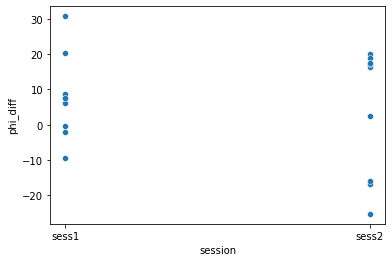

In [100]:
import pandas as pd
import seaborn as sns

trainset1_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset1_estPhi.csv').query('ifold=="6fold"')
trainset2_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset2_estPhi.csv').query('ifold=="6fold"')

trainset1_phi['session'] = 'sess1'
trainset2_phi['session'] = 'sess2'

phi = pd.concat([trainset1_phi,trainset2_phi])
phi['phi_diff'] = phi['ec_phi'] - phi['vmpfc_phi']
sns.scatterplot(data=phi,x='session',y='phi_diff')

phi_diff_sess1 = abs(phi.query("session=='sess1'")['phi_diff']).to_list()
phi_diff_sess2 = abs(phi.query("session=='sess2'")['phi_diff']).to_list()
from scipy.stats import ttest_ind

t,p = ttest_ind(phi_diff_sess1,phi_diff_sess2)
print('p:',round(p,3))

# add covariate:Age

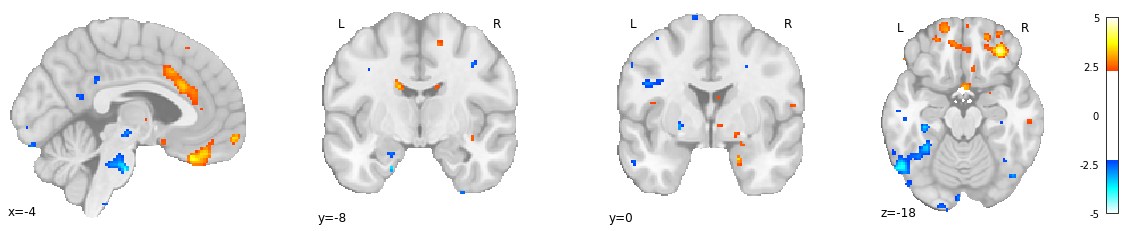

In [29]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariate:2D acc

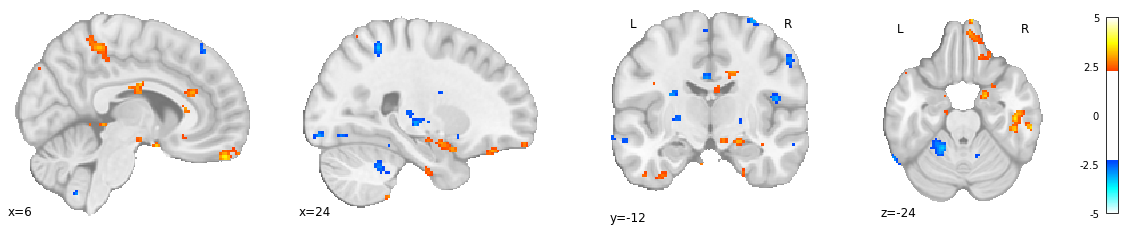

In [30]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-12],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariates: age and acc

### Age

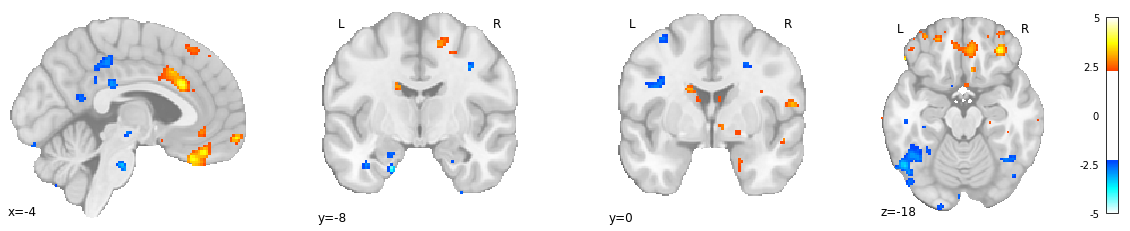

In [31]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

cut_coords = [-4,2,-18]

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

### Acc

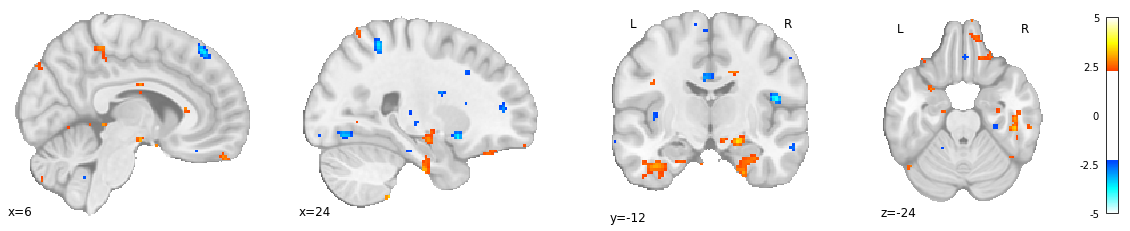

In [32]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0003.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-12],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

/home/dell/.local/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


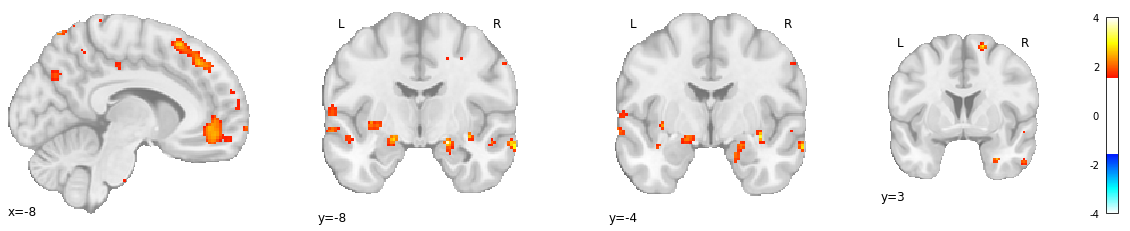

In [102]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_roi
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/'
                    r'hp/2ndLevel/_contrast_id_ZF_0004/spmT_0001.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

vmpfc_mask = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/mPFC_Grid_roi.nii')

stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[3],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# EC

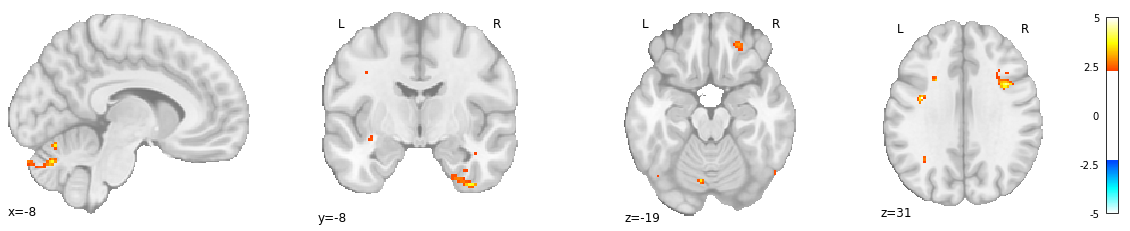

In [87]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/test_set/EC/group/hp/mean_spmT_align_EC_Phi.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')


stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-19],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[31],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)
% md
# vmpfc

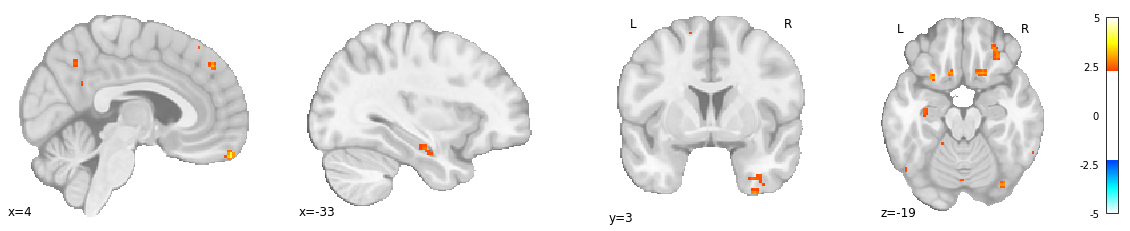

In [86]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/test_set/vmpfc/group/hp/mean_spmT_align_vmpfc_Phi.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')


stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-33],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[3],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-19],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

## copy data for he li

In [ ]:
import shutil

original_dir = r''
